# Agent Behaviour Model - Heuristic

## Price in Bonding Curve

**Step 0: Set parameters for computing realized price $\bar P$**
    
The parameter $\beta \in [0,1]$ is a notion of preciseness or granularity of the line search. We set $\beta$ to 0.9. <br/>
The parameter $dust \in (0,1)$ is chosen such that the line search process has sufficient decrease to lead to convergence. We set $dust = 10^{-8}$ to use in the Armijo style approximation. Note: $dust = 0$ is simple decrease.

**Step 1: Draw $\hat P$ from a signal representing movement of $\hat P$ over time**

Since the agent's private belief of price $\hat P$ is unknown to the designer, it can be sampled from a signal that represents its value at a given timestep. 

The designer may test the system using the following $\hat P$ candidate signals:
1. Martingale / Random walk
2. Step
3. Ramp
4. Sine

**Step 2: Draw current price P** 

An agent makes an bond/burn action based on the difference between the system-level price $P$ and their private belief of the price, $\hat P$

**Step 3: Compute the realized price $\bar P$**

Employ burn or bond functions to compute RP <br/>
$RP = \kappa \frac{R^{\frac{\kappa-1}{\kappa}}}{V^{1/\kappa}} if \Delta s == 0$ <br/>
$RP = \frac{\Delta r}{\Delta s}$ otherwise

Compute $amt$ using Armijo rule <br/>
$max_{amt} = s(1 - dust)$ 

Compute $\bar P$ <br/>
$\bar P = \infty$ if $\Delta r > 0$ <br/>
$\bar P = P$ if $max_{amt} = 0$ <br/>
$\bar P = RP$ otherwise

**Step 4: Determine direction and size of agent's action**


Let $\tau$ be the threshold condition for the agent to make a bond/burn action. $P$ and $\hat P$ need to differ by an amount greater than $\tau$ for the agent to make a bond/burn action. 

We computed a temporary $max_{amt}$ in Step 3 using the Armijo rule. <br/>
$max_{amt} = S(1 - dust)$ 

If $\hat P - \bar P > \tau$, the agent *bonds* with an $amttobond = amt * \beta$

If $\bar P - \hat P > \tau$, the agent *burns* with an $amttoburn = amt * \beta$



1. Compare $\hat{P}$ to $P$ with $\tau$ to determine direction, employ hysteresis
    - Bond 
    - Do nothing
    - Burn
2. If bond:  

    $\Delta{R}$ = max_action = r(1-dust)
   
    Check what RP based on max_action is:
    
```
        proto_RP = deltaR/deltaS
        if proto_RP > Phat:
            iterate, go down
            reduce by beta (0.9)
            repeat with while loop until proto_RP = Phat
         else:
             bond with max_action
```

## $\alpha$ in Prediction Market

**Step 1: Draw $\Theta$**

We know that an agent makes an attestation action to ultimately improve their payout $\Theta$ at settlement. At the time of attestation, the agent does not know their future payout, and thus only has an expectation of their payout $\mathbb{E}(\Theta)_{t}$.

**Step 2: At each action event, draw $\hat\alpha$ randomly from a probability distribution of possible $\hat\alpha$'s**

Since the agent's private belief of alpha, $\hat\alpha$ is unknown to the designer, it needs to be randomly sampled from potential $\hat\alpha$ probability distributions that a system can realistically adopt. 

The designer may test the system using the following $\hat\alpha$ probability distribution candidates:
1. Gaussian
2. Uniform 
3. Bimodal

**Step 3: Conditioned on $\hat\alpha$, compute $\Delta s$**

To account for variations in agent's uncertainty at extremes i.e when $\alpha = 0$ or $\alpha = 1$, we define a threshold band between $g_1$ and $g_0$. The thickness of the band represents the range of $\Delta s$ choices that an agent searches whilst making an attestation. Typically, the band is fat at  $\alpha = 0.5$ since the agent is uncertain about how many tokens to attest. However, at the extremes $\alpha = 0$ and $\alpha = 1$, the agent's search range decreases as they are more confident about their choice of $\Delta s$.

$d$ modulates the curvature of the band. A small $d$ indicates that the agents are equally uncertain at means and extremes. A large $g$ indicates that agents are very uncertain at $\alpha = 0.5$ but relatively certain at the extremes $\alpha = 0$ and $\alpha = 1$.
<br/><br/>
$f$ is a parameter that controls whether the agents are fully certain at the extremes.
<br/>
$$d = 4\sigma(1-\alpha)(\alpha)$$

<img src="img/alphathreshold.png" width="500">

The upper band $g_1$ is defined by
$$g_1 = d + (1-d-f)\alpha + f$$

The lower band $g_0$ is defined by
$$g_0 = (1-d-f)\alpha$$

$$max\_attest = ps + (g_1-g_0)$$
$$min\_attest = ps - (g_1-g_0)$$
where $p$ is the designer-defined percentage of $s$ tokens that the agent considers attesting with

$$\Delta s = rand(min\_attest, max\_attest)$$


**Step 4: Conditioned on $\Delta s$, compute $\bar\alpha$**
 
While making an attestation, the agent realizes a transient alpha called realized alpha $\bar\alpha$

If the agent has made a positive attestation, realized alpha $\bar\alpha$ is

$$\bar\alpha = \frac{\Delta s}{S} \frac{R}{B}$$ 
<br/> where $B = (C+R)\left[\frac{q_1+\Delta q_1}{Q_1+\Delta q1}\frac{S_1+\Delta S}{S}-\frac{q_1}{Q_1}\frac{S_1}{S}\right]-(C)\left[\frac{\Delta s}{S}\right]$

If the agent has made a negative attestation, realized alpha $\bar\alpha$ is

$$\bar\alpha = \frac{R(B - \frac{\Delta s}{S})}{\frac{\Delta s}{S}(C)-B(R)}$$ where $B=\left[\frac{q_0+\Delta q_0}{Q_0+\Delta q_0} \frac{S_0+\Delta s}{S} - \frac{q_0}{Q_0} \frac{S_0}{S}\right]$ 

**Step 5: Conditioned on $\bar\alpha$, compute $\alpha_{t+1}$**

This attestation action in turn moves the system alpha $\alpha$ closer to the agent's private belief of alpha, $\hat\alpha$.

The system alpha state variable changes from $\alpha_{t} \rightarrow \alpha_{t+1}$, computed by

$$\alpha_{t+1} = (\epsilon) \alpha + (1-\epsilon)\cdot(1-\delta) \alpha + (1-\epsilon).(\delta) \bar\alpha$$
<br/> where $\epsilon$ is the designer-defined fixed weight between [0,1] and $\delta=\frac{\Delta s}{S_1+S_0+\Delta s}$ is the dynamic weight.


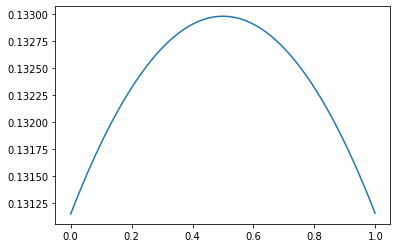

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Plot between -10 and 10 with .001 steps.
x_axis = np.arange(0, 1, 0.001)
# Mean = 0, SD = 2.
plt.plot(x_axis, norm.pdf(x_axis,0.5,3))
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1702: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


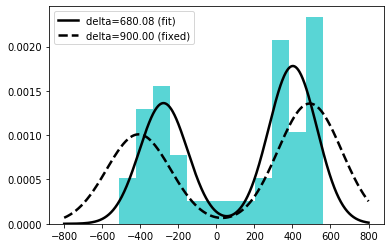

In [1]:
from __future__ import division
from scipy.stats import rv_continuous
import numpy as np
import matplotlib.pyplot as plt


class norm2_gen(rv_continuous):
    def _argcheck(self, *args):
        return True

    def _pdf(self, x, m, s, w, delta):
        phi = 0.5 + np.arctan(w)/np.pi
        return np.exp(-(x-m+delta/2)**2 / (2. * s**2)) / np.sqrt(2. * np.pi * s**2) * phi + \
               np.exp(-(x-m-delta/2)**2 / (2. * s**2)) / np.sqrt(2. * np.pi * s**2) * (1 - phi)

norm2 = norm2_gen(name='norm2')


data = [0,0,0, 0.1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.9, 1, 1, 1]

# In the fit method, the positional arguments after data are the initial
# guesses that are passed to the optimization routine that computes the MLE.
# First let's see what we get if delta is not fixed.
m, s, w, delta, loc, scale = norm2.fit(data, 1.0, 1.0, 0.0, 900.0, floc=0, fscale=1)

# Fit the disribution with delta fixed.
fdelta = 900
m1, s1, w1, delta1, loc, scale = norm2.fit(data, 1.0, 1.0, 0.0, fdelta=fdelta, floc=0, fscale=1)

plt.hist(data, bins=12, normed=True, color='c', alpha=0.65)
q = np.linspace(-800, 800, 1000)
p = norm2.pdf(q, m, s, w, delta)
p1 = norm2.pdf(q, m1, s1, w1, fdelta)
plt.plot(q, p, 'k', linewidth=2.5, label='delta=%6.2f (fit)' % delta)
plt.plot(q, p1, 'k--', linewidth=2.5, label='delta=%6.2f (fixed)' % fdelta)
plt.legend(loc='best')
plt.show()

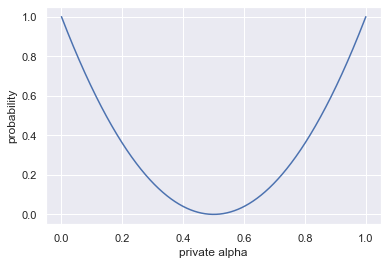

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
data = []
data.append([])
data.append([])
ran = 1000
for x in range (ran+1):
    shift=(ran/2)
    value = (x-shift)**2 
    data[0].append(x/ran)
    data[1].append(value/shift**2)
#print(data)
#data = [0,0,0, 0.1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.9, 1, 1, 1]
plt.plot(data[0], data[1])
plt.xlabel('private alpha')
plt.ylabel('probability')
plt.show()

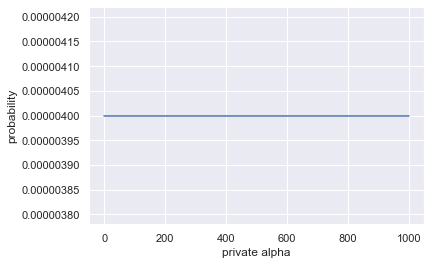

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
data = []
data.append([])
data.append([])
ran = 1000
for x in range (ran+1):
    shift=(ran/2)
    value = (x)**0 
    data[0].append(x-shift/ran)
    data[1].append(value/shift**2)
#print(data)
#data = [0,0,0, 0.1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.9, 1, 1, 1]
plt.plot(data[0], data[1])
plt.xlabel('private alpha')
plt.ylabel('probability')
plt.show()

[[1 7 2 5 2 3]]


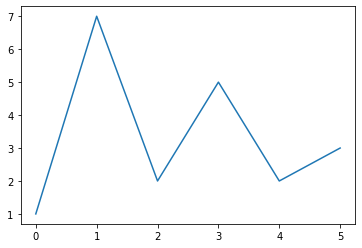

In [1]:
import numpy as np
import matplotlib.pyplot as plt

lol = np.random.multinomial(20, [1/6.]*6, size=1)
print(lol)
plt.plot(lol[0])
plt.show()

In [3]:
from scipy.stats import geninvgauss

In [4]:
p, b = 2.3, 1.5
mean, var, skew, kurt = geninvgauss.stats(p, b, moments='mvsk')

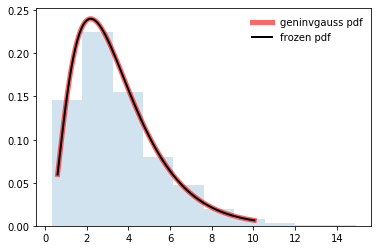

In [15]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(geninvgauss.ppf(0.01, p, b),geninvgauss.ppf(0.99, p, b), 100)
ax.plot(x, geninvgauss.pdf(x, p, b),'r-', lw=5, alpha=0.6, label='geninvgauss pdf')
rv = geninvgauss(p, b)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')
vals = geninvgauss.ppf([0.001, 0.5, 0.999], p, b)
np.allclose([0.001, 0.5, 0.999], geninvgauss.cdf(vals, p, b))
r = geninvgauss.rvs(p, b, size=1000)
ax.hist(r, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()

In [16]:
from scipy.stats import invgauss

In [17]:
mu = 0.145
mean, var, skew, kurt = invgauss.stats(mu, moments='mvsk')

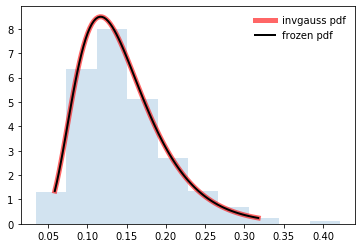

In [18]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(invgauss.ppf(0.01, mu),invgauss.ppf(0.99, mu), 100)
ax.plot(x, invgauss.pdf(x, mu),'r-', lw=5, alpha=0.6, label='invgauss pdf')
rv = invgauss(mu)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')
vals = invgauss.ppf([0.001, 0.5, 0.999], mu)
np.allclose([0.001, 0.5, 0.999], invgauss.cdf(vals, mu))
r = invgauss.rvs(mu, size=1000)
ax.hist(r, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()

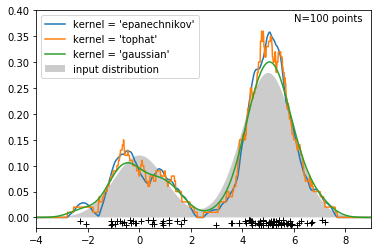

In [19]:
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

# Plot a 1D density example
N = 100
np.random.seed(1)
X = np.concatenate((np.random.normal(0, 1, int(0.3 * N)),
                    np.random.normal(5, 1, int(0.7 * N))))[:, np.newaxis]

X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

true_dens = (0.3 * norm(0, 1).pdf(X_plot[:, 0])
             + 0.7 * norm(5, 1).pdf(X_plot[:, 0]))

fig, ax = plt.subplots()
ax.fill(X_plot[:, 0], true_dens, fc='black', alpha=0.2,
        label='input distribution')

for kernel in ['epanechnikov', 'tophat', 'gaussian']:
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(X_plot[:, 0], np.exp(log_dens), '-',
            label="kernel = '{0}'".format(kernel))

ax.text(6, 0.38, "N={0} points".format(N))

ax.legend(loc='upper left')
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 0.4)
plt.show()

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Beta(0.1,0.1)')]

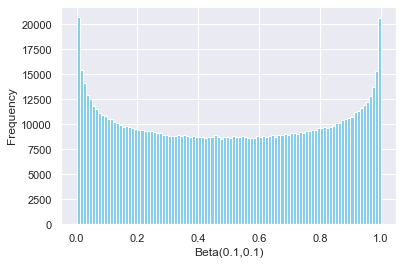

In [45]:
# for inline plots in jupyter
%matplotlib inline
# import matplotlib
import matplotlib.pyplot as plt

# import seaborn
import seaborn as sns
# settings for seaborn plotting style
#sns.set(color_codes=True)
# settings for seaborn plot sizes
#sns.set(rc={'figure.figsize':(4.5,3)})
from scipy.stats import beta

data_beta = beta.rvs(0.8, 0.8, size=1000000)
ax = sns.distplot(data_beta,
                  kde=False,
                  bins=100,
                  color='skyblue',
                  hist_kws={"linewidth": 1,'alpha':1})
ax.set(xlabel='Beta(0.1,0.1)', ylabel='Frequency')

(array([1.30200444, 0.98400335, 0.92900317, 0.85800293, 0.88300301,
        0.880003  , 0.87800299, 0.91900313, 1.00800344, 1.35900463]),
 array([2.61282401e-06, 1.00002272e-01, 2.00001931e-01, 3.00001590e-01,
        4.00001249e-01, 5.00000908e-01, 6.00000567e-01, 7.00000226e-01,
        7.99999885e-01, 8.99999544e-01, 9.99999203e-01]),
 <a list of 1 Patch objects>)

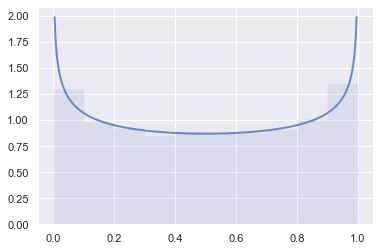

In [93]:
from scipy.stats import beta
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

a, b = 0.8, 0.8
#mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')

x = np.linspace(beta.ppf(0.01, a, b),beta.ppf(0.99, a, b), 1000)
ax.plot(x, beta.pdf(x, a, b), 'b-', lw=2, alpha=0.8, label='beta pdf')

data_beta = beta.rvs(0.8, 0.8, size=10000)
ax.hist(data_beta, density=True, histtype='stepfilled', alpha=0.1)

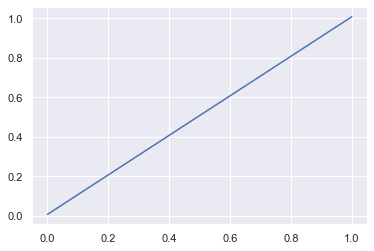

In [101]:
import random
import matplotlib.pyplot as plt

mu_a = 0
sig_a = 0.5

mu_b = 1
sig_b = 0.5

r = random.uniform(0,1)

x1 = [sig_a*r + mu_a, sig_b*r + mu_b]

plt.plot(x1)
plt.show()